In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['lines.markersize'] = 7

In [2]:
# This works on Stephen's computer but not elsewhere
# so if it gives you an error, just don't worry about it
# and don't evaluate this cell
mpl.rcParams['font.serif'] = ['Computer Modern']
from matplotlib import rc
rc('text', usetex=True) 

In [12]:
# True weights and starting weights

np.random.seed(17)

d1 = 10
d2 = 1

m_true = 20
A_true = np.random.randn(m_true,d1)*np.sqrt(2/m_true)
B_true = np.random.randn(m_true,m_true)*np.sqrt(2/m_true)
C_true = np.random.randn(d2,m_true)*np.sqrt(1/d2)

m = 10
A0 = np.random.randn(m,d1)*np.sqrt(2/m)
B0 = np.random.randn(m,m)*np.sqrt(2/m)
C0 = np.random.randn(d2,m)*np.sqrt(1/d2)

In [13]:
def relu(x):
    y = np.maximum(0,x)
    return y

def grad(A,B,C,x,y):
    m = np.shape(B)[0]
    D1 = np.zeros(m)
    D2 = np.zeros(m)
    z = A@x
    D1[z >= 0] = 1
    D1 = np.diag(D1)
    D1Ax = D1@z
    z = B@D1Ax
    D2[z >= 0] = 1
    D2 = np.diag(D2)
    D2BD1Ax = D2@z
    z = C@D2BD1Ax-y
    obj = .5*la.norm(z)**2
    CD2 = C@D2
    CD2BD1 = CD2@B@D1
    der_A = np.outer(CD2BD1.T@z,x)
    der_B = np.outer(CD2.T@z,D1Ax)
    der_C = np.outer(z,D2BD1Ax)
    return [obj,der_A,der_B,der_C]

def gradset(A,B,C,X,Y):
    # TODO: can we vectorize this??
    
    n = np.shape(X)[0]
    objset = 0
    derset_A = np.zeros(np.shape(A))
    derset_B = np.zeros(np.shape(B))
    derset_C = np.zeros(np.shape(C))
    for i in range(n):
        x = X[i,:]
        y = Y[i,:]
        [obj,der_A,der_B,der_C] = grad(A,B,C,x,y)
        objset += obj
        derset_A += der_A
        derset_B += der_B
        derset_C += der_C
    objset /= n
    derset_A /= n
    derset_B /= n
    derset_C /= n
    return [objset,derset_A,derset_B,derset_C]

In [15]:
def sgd(A, B, C, A_true, B_true, C_true, step_size, niter, batch_size, n_test, niter_test, n_validation):
    
    
    # draw niter_test iterates
    p = np.arange(niter)
    p = 1/np.sqrt(p+1)
    p = p/np.sum(p)
    sampled_iterates = np.random.choice(niter,size=niter_test,replace=True,p=p)
    sampled_iterates = np.unique(sampled_iterates)
    sampled_iterate_index = 0
    sampled_iterate = sampled_iterates[sampled_iterate_index]
    sampled_iterate_final = sampled_iterates[len(sampled_iterates)-1]
    
    
    # draw test and validation sets
    d1 = np.shape(A)[1]
    
    X_test = np.random.randn(n_test,d1)
    X_test /= la.norm(X_test,axis=1).reshape(n_test,1)
    Y_test = np.transpose(C_true@relu(B_true@relu(A_true@X_test.T)))
    
    X_validation = np.random.randn(n_validation,d1)
    X_validation /= la.norm(X_validation,axis=1).reshape(n_validation,1)
    Y_validation = np.transpose(C_true@relu(B_true@relu(A_true@X_validation.T)))
    

    # apply sgd
    error = np.inf
    for i in range(niter):
        
        # draw stochastic gradient
        if batch_size == 1:
            x = np.random.randn(d1)
            x /= la.norm(x)
            y = C_true@relu(B_true@relu(A_true@x))
            [obj,der_A,der_B,der_C] = grad(A,B,C,x,y)
        else:
            X = np.random.randn(batch_size,d1)
            X /= la.norm(X,axis=1).reshape(batch_size,1)
            Y = np.transpose(C_true@relu(B_true@relu(A_true@X.T)))
            [obj,der_A,der_B,der_C] = gradset(A,B,C,X,Y)
        
        # take gradient step
        eta = step_size/np.sqrt(i+1)
        A = A-eta*der_A
        B = B-eta*der_B
        C = C-eta*der_C
        
        # compute test error for sampled iterates
        if i == sampled_iterate:
            [obj,der_A,der_B,der_C] = gradset(A,B,C,X_test,Y_test)
            new_error = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
            if new_error < error:
                error = new_error
                A_best = A
                B_best = B
                C_best = C
            if sampled_iterate != sampled_iterate_final:
                sampled_iterate_index += 1
                sampled_iterate = sampled_iterates[sampled_iterate_index]
        
        
    # compute validation error for best iterate and last iterate
    [obj,der_A,der_B,der_C] = gradset(A_best,B_best,C_best,X_validation,Y_validation)
    b_err = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
    [obj,der_A,der_B,der_C] = gradset(A,B,C,X_validation,Y_validation)
    l_err = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
    
    return [b_err,l_err]

In [ ]:
step_size = .1
niter = 1000
batch_size = 10
n_test = 1000
niter_test = 200
n_validation = 5000

num_trials = 100
b_errs = np.zeros(num_trials)
l_errs = np.zeros(num_trials)
for i in range(num_trials):
    print(i)
    A = A0
    B = B0
    C = C0
    [b_err,l_err] = sgd(A, B, C, A_true, B_true, C_true, step_size, niter, batch_size, n_test, niter_test, n_validation)
    b_errs[i] = b_err
    l_errs[i] = l_err
np.savetxt('sa_conv_b_errs.csv', b_errs, delimiter=',')
np.savetxt('sa_conv_l_errs.csv', l_errs, delimiter=',')

In [ ]:
# If needed, download data files
!wget -q https://github.com/liammadden/sgd/raw/main/plots/data/sa_conv_b_errs.csv
!wget -q https://github.com/liammadden/sgd/raw/main/plots/data/sa_conv_l_errs.csv

In [3]:
b_errs = np.loadtxt('sa_conv_b_errs.csv',  delimiter=',')
l_errs = np.loadtxt('sa_conv_l_errs.csv',  delimiter=',')
# b_errs = np.loadtxt('data/sa_conv_b_errs.csv',  delimiter=',')
# l_errs = np.loadtxt('data/sa_conv_l_errs.csv',  delimiter=',')
cdf = np.arange(len(b_errs))/float(len(b_errs))
b_errs = np.sort(b_errs)
l_errs = np.sort(l_errs)

In [5]:
# Find line of best-fit (possibly after doing a transformation)
def bestFit( x, y):
    """ returns slope,intercept for best fit of the data (x,y)"""
    # Form Vandermonde matrix
    n = len(x)
    V = np.vstack( (x.ravel(), np.ones(n)) ).T 
    
    beta = la.lstsq(V,y,rcond=None)[0]

    slope = beta[0]
    intercept = beta[1]

    return slope,intercept

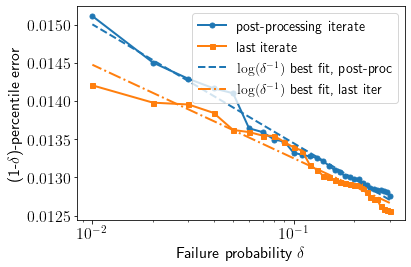

In [39]:
# Figure

deltas = 1-cdf[-30:]
data_b = b_errs[-30:]
data_l = l_errs[-30:]

fig, ax = plt.subplots()
h1=ax.semilogx(deltas,data_b,'o-',markersize=5,label='post-processing iterate')

h2=ax.semilogx(deltas,data_l,'s-',markersize=5,label='last iterate')

# Make a line of best fit, using function dependence f(delta)
f = lambda delta : np.log(1/delta)


clr1 = h1[0].get_color()
clr2 = h2[0].get_color()
slp,intrcpt = bestFit( f(deltas), data_b)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, '--', color=clr1,\
    markevery=.45,label="$\log(\delta^{-1})$ best fit, post-proc")
slp,intrcpt = bestFit( f(deltas), data_l)
ax.semilogx( deltas, slp*f(deltas) + intrcpt, '-.', color=clr2,\
    markevery=.45,label="$\log(\delta^{-1})$ best fit, last iter")


plt.xlabel('Failure probability $\delta$')
plt.ylabel('(1-$\delta$)-percentile error')
# plt.ylim(bottom=0)
legend = ax.legend(fontsize=14)#loc='lower right')
# plt.xlim(right=.1) 
# plt.savefig('saconvergence_v2_zoomed.pdf')
plt.show()

Same plot, but zoom out a bit, and no reference line

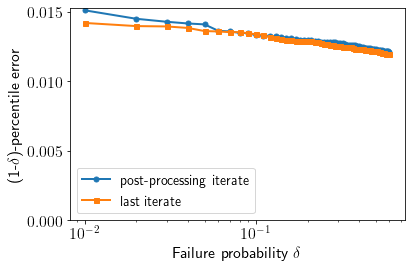

In [38]:
deltas = 1-cdf[-60:]
data_b = b_errs[-60:]
data_l = l_errs[-60:]

fig, ax = plt.subplots()
h1=ax.semilogx(deltas,data_b,'o-',markersize=5,label='post-processing iterate')

h2=ax.semilogx(deltas,data_l,'s-',markersize=5,label='last iterate')

plt.xlabel('Failure probability $\delta$')
plt.ylabel('(1-$\delta$)-percentile error')
plt.ylim(bottom=0)
legend = ax.legend(fontsize=14)#loc='lower right')
# plt.xlim(right=.1) 
# plt.savefig('saconvergence_v2.pdf')
plt.show()